In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *
from Bio import Seq
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import FeatureLocation, CompoundLocation
import networkx as nx

In [3]:
sys.path.append("../..")
from utils import *

In [4]:
path = Path('F:/genome/mammals/')

In [5]:
tok = Tokenizer(GenomicTokenizer, n_cpus=1, pre_rules=[], post_rules=[], special_cases=['xxpad'])

In [7]:
df_valid = pd.read_csv(path/'mammal_val.csv')

In [8]:
df_iter = pd.read_csv(path/'mammal_train.csv', chunksize=1000000)

In [9]:
df = next(df_iter)

In [10]:
df.head()

,Sequence,Source,set
0,TAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAAC...,NCBI Human,train
1,CATCTGCAGGTGTCTGACTTCCAGCAACTGCTGGCCTGTGCCAGGG...,NCBI Human,train
2,ACCTGCCCCACAGCCTTGCCTGGATTTCTATCTCCCTGGCTTGGTG...,NCBI Human,train
3,CTGGGGAAGCTTACTGTGTCCAAGAGCCTGCTGGGAGGGAAGTCAC...,NCBI Human,train
4,TGAAGATGGAGCCATATTCCTGCAGGCGCCCTGGAGCAGGGTACTT...,NCBI Human,train


# Part 1
0-200,000

In [11]:
data = GenomicTextLMDataBunch.from_df(path, df[:200000], df_valid, bs=400, tokenizer=tok, 
                              chunksize=20000, text_cols=0, label_cols=1)

In [ ]:
data.train_ds[0]

In [12]:
np.save(path/'mammal_vocab.npy', data.vocab.itos)

In [14]:
voc = np.load(path/'mammal_vocab.npy')
model_vocab = GenomicVocab(voc)

In [15]:
len(model_vocab.stoi), len(model_vocab.itos)

(1025, 1025)

In [18]:
config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.25, 
                          hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15, tie_weights=True, out_bias=True)
drop_mult = 0.25

In [19]:
learn = get_model_LM(data, drop_mult, config)

In [ ]:
learn.data.train_ds[0]

In [20]:
learn.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(1025, 400, padding_idx=0)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(1025, 400, padding_idx=0)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=1025, bias=True)
    (output_dp): RNNDropout()
  )
)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-03


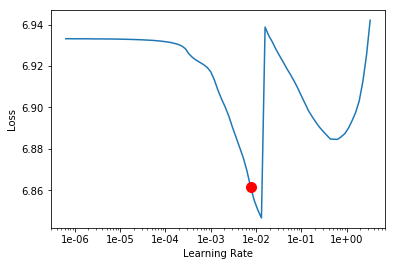

In [22]:
learn.lr_find()
learn.recorder.plot()

In [23]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7), pct_start=0.9)

epoch,train_loss,valid_loss,accuracy
1,2.370264,2.372840,0.233079


# Part 2
200,000-400,000

In [24]:
data = GenomicTextLMDataBunch.from_df(path, df[200000:400000], df_valid, bs=400, tokenizer=tok, vocab=model_vocab,
                              chunksize=20000, text_cols=0, label_cols=1)

In [25]:
learn.data = data

In [26]:
learn.data.train_ds[0]

(Text TTCAT CATAC TACCA CCATT ATTCA TCAAA AAAAT AATTC TTCAG CAGAA GAAGG AGGTA GTACC ACCAA CAAAG AAGAA GAATA ATATA ATACA ACAGT AGTGG TGGAA GAAAG AAGTC GTCTT CTTCC TCCTC CTCCT CCTAC TACTT CTTCT TCTGT TGTTC TTCCC CCCAA CAATC ATCAC CACTC CTCAA CAATT ATTAC TACCC CCCAC CACCC CCCCA CCAGA AGAGG AGGCA GCAAT AATCG TCGAT GATTT TTTCT TCTTA TTATG ATGTA GTATC ATCCT CCTTC TTCTA CTAGA AGAGA AGATG ATGTT GTTTT TTTAT TATCC TCCAT CATAA TAAAC AACAA CAAGT AGTAA TAAAT AATTA TTATA ATATA ATATA ATATA ATAAT AATGT TGTTA TTAAT AATAT TATAT TATAT TATAC TACAT CATCC TCCAA CAAAT AATAT TATAT TATGT TGTGT TGTGT TGTAT TATAT TATAT TATGA TGAAA AAATT ATTCT TCTTA TTACC ACCAT CATTT TTTCT TCTTT TTTTT TTTAT TATAT TATAA TAAAT AATGA TGATA ATAGC AGCAT CATAC TACTA CTATT ATTTA TTATA ATACC ACCGT CGTCC TCCTA CTATA ATACA ACATC ATCTT CTTGC TGCTT CTTTT TTTGT TGTCG TCGAA GAATT ATTCA TCAGT AGTCC TCCTT CTTTT TTTGA TGAAA AAAAG AAGAA GAAAT AATTT TTTAG TAGCA GCAAT AATAT TATAT TATAG TAGGT GGTAC TACAT CATAC TACAC CACAC CACAA CAAGT AGTAT TATAC TACA

In [27]:
lr = 1e-2/1.35

In [28]:
learn.fit_one_cycle(1, lr, moms=(0.8,0.7), pct_start=0.9)

epoch,train_loss,valid_loss,accuracy
1,2.332373,2.310076,0.255104


In [29]:
learn.save('mammal_in_training')

# Part 3

400,000-700,000

In [30]:
data = GenomicTextLMDataBunch.from_df(path, df[400000:700000], df_valid, bs=400, tokenizer=tok, vocab=model_vocab,
                              chunksize=20000, text_cols=0, label_cols=1)

In [31]:
learn.data = data

In [32]:
learn.data.train_ds[0]

(Text AGAGA AGATA ATACT ACTAA TAATA ATATA ATATT ATTTT TTTTA TTAAT AATTG TTGTT GTTTT TTTAT TATAA TAAAT AATAA TAATC ATCTA CTACC ACCTT CTTTT TTTAT TATTT TTTTG TTGGG GGGGG GGGAG GAGGA GGAAA AAACA ACATC ATCCT CCTCA TCAAG AAGTG GTGTC GTCAG CAGGG GGGAG GAGTC GTCTC CTCAA CAAGC AGCTA CTAAG AAGAA GAAAA AAATA ATAGT AGTCT TCTTC TTCCA CCACC ACCCA CCAAC AACAT CATTT TTTCA TCAAA AAAGA AGAGG AGGCT GCTAC TACGA CGAGC AGCCA CCAAC AACTC CTCAT CATTT TTTTT TTTGG TGGGG GGGGA GGATA ATAGC AGCCA CCATA ATATT ATTCT TCTCA TCAGC AGCAG CAGGG GGGAA GAAAG AAGGG GGGGC GGCAA CAAGA AGACC ACCCT CCTTT TTTTC TTCCA CCAGG AGGTA GTAAG AAGAT GATTC TTCCT CCTCT TCTCT TCTTG TTGAG GAGAA GAACT ACTAA TAAGC AGCTT CTTCT TCTCT TCTTG TTGGC GGCCA CCACA ACAGG AGGTG GTGGG GGGTC GTCAG CAGTT GTTTA TTAGT AGTCA TCAGT AGTGA TGAGG AGGGT GGTCT TCTTA TTAGG AGGGC GGCTG CTGTA GTATT ATTTT TTTGT TGTTT TTTCC TCCTA CTACT ACTGT TGTTG TTGCT GCTGG TGGGT GGTTA TTAGT AGTAT TATGG TGGCT GCTAC TACCT CCTGC TGCCC CCCTA CTAGG AGGTC GTCCA CCAAC AACCT CCTGT TGTCC TCCC

In [33]:
lr = 1e-2/1.35**2

In [34]:
learn.fit_one_cycle(1, lr, moms=(0.8,0.7), pct_start=0.9)

epoch,train_loss,valid_loss,accuracy
1,2.263601,2.244481,0.279138


In [35]:
learn.save('mammal_in_training')

# Part 4

700,000 - 1,000,000

In [36]:
data = GenomicTextLMDataBunch.from_df(path, df[700000:], df_valid, bs=400, tokenizer=tok, vocab=model_vocab,
                              chunksize=20000, text_cols=0, label_cols=1)

In [37]:
learn.data = data

In [38]:
learn.data.train_ds[0]

(Text GGCTA CTAAA AAATT ATTGC TGCAA CAAGT AGTCC TCCAA CAATC ATCTA CTATT ATTTT TTTTC TTCTG CTGAT GATCT TCTTA TTATG ATGTG GTGTT GTTCA TCACC ACCTG CTGAA GAAAG AAGCA GCAAA AAAAT AATAA TAATG ATGAG GAGTT GTTCA TCAGA AGATA ATATT ATTCT TCTTG TTGCA GCATG ATGGA GGAAA AAACA ACATA ATACT ACTCA TCATT ATTGT TGTGA TGATC ATCAG CAGAA GAATG ATGAA GAAGG AGGAA GAAGT AGTTA TTATT ATTGC TGCTA CTAAT AATGC TGCAC CACTT CTTAC TACAA CAAAT AATAT TATGT TGTTT TTTAT TATCC TCCCT CCTGC TGCGA CGAGC AGCTA CTAAT AATGT TGTGT TGTCT TCTCA TCAAT AATTC TTCCT CCTGA TGAAA AAAGT AGTCA TCATT ATTAT TATTA TTACC ACCTT CTTGC TGCTC CTCCT CCTTT TTTCT TCTAG TAGTA GTATT ATTTT TTTAA TAAAA AAAGA AGATG ATGAA GAAAA AAAAG AAGTG GTGAT GATAA TAAAT AATTT TTTCA TCAAA AAAAT AATAA TAATA ATAAA AAAAC AACAT CATCA TCATT ATTAT TATTT TTTTT TTTGA TGACA ACATT ATTGA TGAGG AGGAT GATGT TGTCA TCATT ATTTT TTTGT TGTAA TAAAT AATTA TTAAC AACCT CCTAT TATGA TGACA ACATT ATTTT TTTTA TTACT ACTTT TTTTT TTTGG TGGTT GTTAA TAATC ATCCT CCTTC TTCAG CAGAT GATTT TTTAC TACTC CTCT

In [39]:
lr = 1e-2/1.35**3

In [40]:
learn.fit_one_cycle(1, lr, moms=(0.8,0.7), pct_start=0.9)

epoch,train_loss,valid_loss,accuracy
1,2.244592,2.207216,0.293235


In [41]:
learn.save('mammal_in_training')

# Part 5

df 1,000,000 - 2,000,000

0-200,000

In [42]:
df = next(df_iter)

In [43]:
df.head()

,Sequence,Source,set
1000000,CATTGTTTTCATTCTCCATGACCGCTGTGGGTCACTTTCTATTATT...,NCBI Human,train
1000001,CACTTCAAAATGAAAAAATAATTATTGGAACTACATTGGGGGAACT...,NCBI Human,train
1000002,CAGTACAGCAGAATTCAAGGTCAGGGTAATTGCTTTCAGACAATAC...,NCBI Human,train
1000003,GATGGGGAAGAGTCAAGAACAGACAGCAGACGAGAAAAATAAATGA...,NCBI Human,train
1000004,AAGTAAATTGAAAACCTAGACAAGATTTTCCATTCTAGATGCCATT...,NCBI Human,train


In [44]:
data = GenomicTextLMDataBunch.from_df(path, df[:200000], df_valid, bs=400, tokenizer=tok, vocab=model_vocab,
                              chunksize=20000, text_cols=0, label_cols=1)

In [45]:
learn.data = data

In [46]:
learn.data.train_ds[0]

(Text CATTG TTGTT GTTTT TTTCA TCATT ATTCT TCTCC TCCAT CATGA TGACC ACCGC CGCTG CTGTG GTGGG GGGTC GTCAC CACTT CTTTC TTCTA CTATT ATTAT TATTT TTTGG TGGCC GCCTT CTTCA TCATC ATCCA CCAAA AAACT ACTCT TCTGA TGATG ATGCT GCTCA TCATC ATCTG CTGAA GAAGT AGTTT TTTAC TACAC CACTA CTATT ATTCT TCTAT TATTA TTATA ATAAC AACAT CATTC TTCTT CTTTT TTTTG TTGTA GTAAT AATTT TTTTA TTATT ATTGT TGTTA TTATC ATCAT CATAT TATGT TGTGG TGGAC GACCT CCTCC TCCAG CAGTC GTCAT CATAT TATCT TCTCT TCTAC TACAT CATTT TTTCT TCTTG TTGAG GAGGG GGGTT GTTTC TTCAG CAGTA GTATT ATTTG TTGAT GATTC TTCCT CCTAA TAATA ATATC ATCTA CTACC ACCCC CCCAC CACCT CCTCA TCATC ATCCC CCCCT CCTAG TAGTA GTAAA AAAAT AATGC TGCAG CAGCA GCACT ACTAC TACAG CAGCA GCATA ATAGT AGTGT TGTTT TTTAA TAAGA AGAGC AGCAC CACAA CAAGT AGTTA TTAGA AGACA ACAAC AACTC CTCAA CAAGG AGGTC GTCAA CAAGT AGTAC TACCA CCAAA AAATC ATCTA CTACC ACCCC CCCTC CTCAT CATTA TTAAC AACAT CATGT TGTAA TAACC ACCTT CTTGG TGGGA GGAGG AGGCC GCCAG CAGCT GCTAA TAATG ATGTT GTTTC TTCAA CAATG ATGCC GCCTC CTCAG CAGT

In [47]:
lr = 1e-2/1.35**4

In [48]:
learn.fit_one_cycle(1, lr, moms=(0.8,0.7), pct_start=0.9)

epoch,train_loss,valid_loss,accuracy
1,2.234741,2.197642,0.297131


In [49]:
learn.save('mammal_in_training')

# Part 6

200,000 - 400,000

In [50]:
data = GenomicTextLMDataBunch.from_df(path, df[200000:400000], df_valid, bs=400, tokenizer=tok, vocab=model_vocab,
                              chunksize=20000, text_cols=0, label_cols=1)

In [51]:
learn.data = data

In [52]:
learn.data.train_ds[0]

(Text CACTA CTAAT AATTA TTAGA AGAGA AGATT ATTAA TAATC ATCTT CTTGC TGCTG CTGTT GTTGG TGGGT GGTAA TAATA ATATT ATTGA TGAGC AGCTT CTTCT TCTGA TGAAA AAAGT AGTTC TTCCG CCGTC GTCAC CACTT CTTAT TATTC TTCAA CAAAG AAGCA GCAGT AGTGA TGAAT AATAA TAATC ATCCT CCTTA TTAAT AATAC TACTG CTGAA GAAGT AGTTG TTGGT GGTAA TAACT ACTTC TTCTA CTATG ATGTT GTTGC TGCCA CCACT ACTAT TATCT TCTTC TTCAA CAACC ACCAT CATGC TGCAT CATAC TACTT CTTCT TCTTT TTTCT TCTAG TAGGA GGATG ATGGA GGAAC AACCA CCAAC AACCT CCTCA TCAAA AAAAA AAAGA AGAAA AAAAG AAGTC GTCCA CCAAA AAAGT AGTAC TACAG CAGCT GCTTG TTGGA GGATT ATTTG TTGGT GGTTT TTTAG TAGAT GATAA TAAGT AGTTA TTATT ATTAG TAGGT GGTCA TCACT ACTCA TCAGT AGTTG TTGCA GCACA ACAGG AGGTT GTTCC TCCTA CTAAA AAAAG AAGTC GTCAT CATTT TTTTC TTCAG CAGGC GGCTT CTTTG TTGTA GTAGG AGGTA GTAGG AGGTG GTGGA GGAAA AAAAA AAAAG AAGAG GAGCT GCTTG TTGAT GATAA TAATA ATAAT AATTG TTGAA GAATA ATAAT AATGG TGGAA GAAGT AGTAA TAACT ACTTT TTTTA TTAGC AGCCT CCTAT TATAT TATTT TTTTA TTACA ACAAA AAAAA AAAAG AAGAC GACCT CCTA

In [53]:
lr = 1e-2/1.35**5

In [54]:
learn.fit_one_cycle(1, lr, moms=(0.8,0.7), pct_start=0.9)

epoch,train_loss,valid_loss,accuracy
1,2.130705,2.186655,0.301050


In [55]:
learn.save('mammal_in_training')

# Part 7

400,000-700,000

In [ ]:
data = GenomicTextLMDataBunch.from_df(path, df[400000:700000], df_valid, bs=400, tokenizer=tok, vocab=model_vocab,
                              chunksize=20000, text_cols=0, label_cols=1)

In [ ]:
learn.data = data

In [ ]:
learn.data.train_ds[0]

In [ ]:
lr = 1e-2/1.35**6

In [ ]:
learn.fit_one_cycle(1, lr, moms=(0.8,0.7), pct_start=0.9)

In [ ]:
learn.save('mammal_in_training')

# Part 8

700,000 - 1,000,000

In [ ]:
data = GenomicTextLMDataBunch.from_df(path, df[700000:], df_valid, bs=400, tokenizer=tok, vocab=model_vocab,
                              chunksize=20000, text_cols=0, label_cols=1)

In [ ]:
learn.data = data

In [ ]:
learn.data.train_ds[0]

In [ ]:
lr = 1e-2/1.35**7

In [ ]:
learn.fit_one_cycle(1, lr, moms=(0.8,0.7), pct_start=0.9)

In [ ]:
learn.save('mammal_in_training')

# Part 9

df 2,000,000 - 3,000,000

0-200,000

In [ ]:
df = next(df_iter)

In [ ]:
df.head()

In [ ]:
data = GenomicTextLMDataBunch.from_df(path, df[:200000], df_valid, bs=400, tokenizer=tok, vocab=model_vocab,
                              chunksize=20000, text_cols=0, label_cols=1)

In [ ]:
learn.data = data

In [ ]:
learn.data.train_ds[0]

In [ ]:
lr = 1e-2/1.35**8

In [ ]:
learn.fit_one_cycle(1, lr, moms=(0.8,0.7), pct_start=0.9)

In [ ]:
learn.save('mammal_in_training')

# Part 10

200,000 - 400,000

In [ ]:
data = GenomicTextLMDataBunch.from_df(path, df[200000:400000], df_valid, bs=400, tokenizer=tok, vocab=model_vocab,
                              chunksize=20000, text_cols=0, label_cols=1)

In [ ]:
learn.data = data

In [ ]:
learn.data.train_ds[0]

In [ ]:
lr = 1e-2/1.35**9

In [ ]:
learn.fit_one_cycle(1, lr, moms=(0.8,0.7), pct_start=0.9)

In [ ]:
learn.save('mammal_in_training')

# Part 11

400,000-700,000

In [ ]:
data = GenomicTextLMDataBunch.from_df(path, df[400000:700000], df_valid, bs=400, tokenizer=tok, vocab=model_vocab,
                              chunksize=20000, text_cols=0, label_cols=1)

In [ ]:
learn.data = data

In [ ]:
learn.data.train_ds[0]

In [ ]:
lr = 1e-2/1.35**10

In [ ]:
learn.fit_one_cycle(1, lr, moms=(0.8,0.7), pct_start=0.9)

In [ ]:
learn.save('mammal_in_training')

# Part 12

700,000 - 1,000,000

In [ ]:
data = GenomicTextLMDataBunch.from_df(path, df[700000:], df_valid, bs=400, tokenizer=tok, vocab=model_vocab,
                              chunksize=20000, text_cols=0, label_cols=1)

In [ ]:
learn.data = data

In [ ]:
learn.data.train_ds[0]

In [ ]:
lr = 1e-2/1.35**11

In [ ]:
learn.fit_one_cycle(1, lr, moms=(0.8,0.7), pct_start=0.9)

In [ ]:
learn.save('mammal_in_training')

# Part 13

df 3,000,000 - 4,000,000

0-200,000

In [ ]:
df = next(df_iter)

In [ ]:
df.head()

In [ ]:
data = GenomicTextLMDataBunch.from_df(path, df[:200000], df_valid, bs=400, tokenizer=tok, vocab=model_vocab,
                              chunksize=20000, text_cols=0, label_cols=1)

In [ ]:
learn.data = data

In [ ]:
learn.data.train_ds[0]

In [ ]:
lr = 1e-2/1.35**12

In [ ]:
learn.fit_one_cycle(1, lr, moms=(0.8,0.7), pct_start=0.9)

In [ ]:
learn.save('mammal_in_training')

# Part 14

200,000 - 400,000

In [ ]:
data = GenomicTextLMDataBunch.from_df(path, df[200000:400000], df_valid, bs=400, tokenizer=tok, vocab=model_vocab,
                              chunksize=20000, text_cols=0, label_cols=1)

In [ ]:
learn.data = data

In [ ]:
learn.data.train_ds[0]

In [ ]:
lr = 1e-2/1.35**13

In [ ]:
learn.fit_one_cycle(1, lr, moms=(0.8,0.7), pct_start=0.9)

In [ ]:
learn.save('mammal_in_training')

# Part 15

400,000-700,000

In [ ]:
data = GenomicTextLMDataBunch.from_df(path, df[400000:700000], df_valid, bs=400, tokenizer=tok, vocab=model_vocab,
                              chunksize=20000, text_cols=0, label_cols=1)

In [ ]:
learn.data = data

In [ ]:
learn.data.train_ds[0]

In [ ]:
lr = 1e-2/1.35**14

In [ ]:
learn.fit_one_cycle(1, lr, moms=(0.8,0.7), pct_start=0.9)

In [ ]:
learn.save('mammal_in_training')

# Part 16

700,000 - 1,000,000

In [ ]:
data = GenomicTextLMDataBunch.from_df(path, df[700000:], df_valid, bs=400, tokenizer=tok, vocab=model_vocab,
                              chunksize=20000, text_cols=0, label_cols=1)

In [ ]:
learn.data = data

In [ ]:
learn.data.train_ds[0]

In [ ]:
lr = 1e-2/1.35**15

In [ ]:
learn.fit_one_cycle(1, lr, moms=(0.8,0.7), pct_start=0.9)

In [ ]:
learn.save('mammal_in_training')

# check length

# Part 17

df 4,000,000 - 

0-200,000

In [ ]:
df = next(df_iter)

In [ ]:
df.head()

In [ ]:
data = GenomicTextLMDataBunch.from_df(path, df[:200000], df_valid, bs=400, tokenizer=tok, vocab=model_vocab,
                              chunksize=20000, text_cols=0, label_cols=1)

In [ ]:
learn.data = data

In [ ]:
learn.data.train_ds[0]

In [ ]:
lr = 1e-2/1.35**12

In [ ]:
learn.fit_one_cycle(1, lr, moms=(0.8,0.7), pct_start=0.9)

In [ ]:
learn.save('mammal_in_training')

# Part 14

200,000 - 400,000

In [ ]:
data = GenomicTextLMDataBunch.from_df(path, df[200000:400000], df_valid, bs=400, tokenizer=tok, vocab=model_vocab,
                              chunksize=20000, text_cols=0, label_cols=1)

In [ ]:
learn.data = data

In [ ]:
learn.data.train_ds[0]

In [ ]:
lr = 1e-2/1.35**13

In [ ]:
learn.fit_one_cycle(1, lr, moms=(0.8,0.7), pct_start=0.9)

In [ ]:
learn.save('mammal_in_training')

# Part 15

400,000-700,000

In [ ]:
data = GenomicTextLMDataBunch.from_df(path, df[400000:700000], df_valid, bs=400, tokenizer=tok, vocab=model_vocab,
                              chunksize=20000, text_cols=0, label_cols=1)

In [ ]:
learn.data = data

In [ ]:
learn.data.train_ds[0]

In [ ]:
lr = 1e-2/1.35**14

In [ ]:
learn.fit_one_cycle(1, lr, moms=(0.8,0.7), pct_start=0.9)

In [ ]:
learn.save('mammal_in_training')

# Part 16

700,000 - 1,000,000

In [ ]:
data = GenomicTextLMDataBunch.from_df(path, df[700000:], df_valid, bs=400, tokenizer=tok, vocab=model_vocab,
                              chunksize=20000, text_cols=0, label_cols=1)

In [ ]:
learn.data = data

In [ ]:
learn.data.train_ds[0]

In [ ]:
lr = 1e-2/1.35**15

In [ ]:
learn.fit_one_cycle(1, lr, moms=(0.8,0.7), pct_start=0.9)

In [ ]:
learn.save('mammal_in_training')